# Project 1 - Aurèle Bohbot, Quentin Guilhot, Yanis Tournier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import plotly.express as px
from numpy import where
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, f_regression
from sklearn.tree import ExtraTreeRegressor
import math as m
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, ExtraTreesRegressor, AdaBoostRegressor, VotingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import SVR, LinearSVC, SVC, LinearSVR
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

## Reading of the data

In [2]:
X = pd.read_csv('X_train.csv').drop(columns=['id'])
Xt = pd.read_csv('X_test.csv')
y = pd.read_csv('y_train.csv')
to_drop = ['x104', 'x129', 'x489', 'x530']
X = X.drop(columns=to_drop)
y = y.drop(columns=['id'])

## Splitting of the data

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Handling outliers

### Handling missing values and scaling

For the moment, we replace the missing values by the column's median. Depending on the results, we might implement a knn algorithm.

In [4]:
y_test = y_test.fillna(y_test.median())
y_train = y_train.fillna(y_train.median())
X_test = X_test.fillna(X_test.median())

X_train_filled = X_train.fillna(X_train.median())
X_test_filled = X_test.fillna(X_train.median())

## compute the ration of missing values ?


In [5]:
scaler = StandardScaler()
scaler.fit(X_train_filled)
X_train_norm = scaler.transform(X_train_filled)
X_test_norm = scaler.transform(X_test_filled)

### Handling feature selections

In [6]:
# Univariate feature selection with the highest variance
## ToDo : is k=160 the best we can find ?
select_feature = SelectKBest(f_regression, k=(160)).fit(X_train_norm, y_train)
X_train_new = select_feature.transform(X_train_norm)
X_test_new = select_feature.transform(X_test_norm)


/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
# Feature selection with PCA
## ToDo : is n_components=200 
pca = PCA(n_components=200)
pca.fit(X_train_norm,y_train)
X_train_pca = pca.transform(X_train_norm)
X_test_pca= pca.transform(X_test_norm)

## Feature selection/ranking with recursive feature elimination


clf_rf_4 = LinearRegression()
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='r2')   #5-fold cross-validation
rfecv = rfecv.fit(X_train_norm, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train_norm.columns[rfecv.support_])

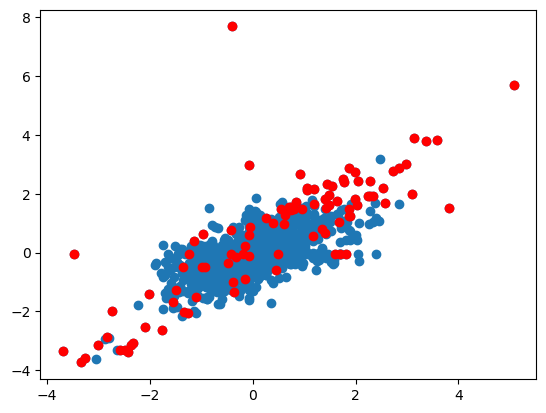

(97, 160) (969, 160)


(array([ 11,  15,  33,  42,  55,  56,  62,  74,  84, 101, 116, 118, 119,
        130, 142, 168, 183, 184, 199, 203, 219, 226, 233, 244, 282, 307,
        319, 322, 332, 359, 395, 419, 434, 442, 443, 446, 447, 452, 459,
        477, 483, 484, 492, 512, 515, 518, 537, 547, 555, 558, 566, 573,
        576, 582, 587, 591, 592, 595, 596, 604, 620, 621, 626, 631, 639,
        658, 686, 704, 715, 718, 726, 728, 729, 755, 774, 800, 811, 816,
        819, 820, 821, 822, 827, 828, 836, 842, 846, 867, 868, 869, 886,
        892, 920, 949, 954, 956, 967]),)

In [8]:
# Outlier detection with multivariate technique: gaussian mixture model
## ToDo : is contamination = 0.1 the best ?
elenv = EllipticEnvelope(contamination=0.1)

pred = elenv.fit_predict(X_train_new)
anom_index=where(pred==-1)
values_anom = X_train_new[anom_index]

plt.scatter(X_train_new[:,0], X_train_new[:,1])
plt.scatter(values_anom[:,0],values_anom[:,1], color='r')
plt.show()
print(values_anom.shape,X_train_new.shape)
anom_index

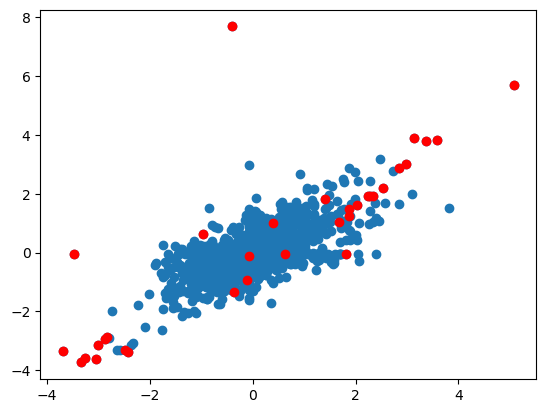

(33, 160) (969, 160)


(array([  9,  62,  84, 130, 142, 184, 199, 210, 322, 359, 442, 468, 483,
        492, 512, 515, 518, 521, 537, 547, 558, 582, 620, 626, 728, 755,
        819, 821, 828, 836, 892, 954, 956]),)

In [9]:
## Outlier detection with multivariate technique: LOF
elenv = LocalOutlierFactor(n_neighbors=55)

pred = elenv.fit_predict(X_train_new)
anom_index=where(pred==-1)
values_anom = X_train_new[anom_index]

plt.scatter(X_train_new[:,0], X_train_new[:,1])
plt.scatter(values_anom[:,0],values_anom[:,1], color='r')
plt.show()
print(values_anom.shape,X_train_new.shape)
anom_index

In [10]:
## What do you with outliers
# 1/ just trying to drop them

X_train_less_outliers = np.delete(X_train_new,anom_index, axis=0)
Y_train_less_outliers = np.delete(y_train.values,anom_index, axis=0)
print(X_train_less_outliers.shape,Y_train_less_outliers.shape)

(936, 160) (936, 1)


In [11]:
#X_pd_final = pd.DataFrame(X_train_less_outliers)
#sns.pairplot(X_pd_final, size = 2.5)

In [12]:
model = LinearRegression()
model.fit(X_train_new, y_train)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)

score

0.2571547550287049

In [13]:
model = Ridge(alpha=1000)
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

0.3317717196628629

In [14]:
model = SVR(kernel='rbf', gamma=0.01, tol=0.001, C=1000, epsilon=0.01, shrinking=True, cache_size=2000, verbose=False, max_iter=-1)
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.600577113453931

In [15]:
model.get_params()

{'C': 1000,
 'cache_size': 2000,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.01,
 'gamma': 0.01,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [16]:
import scipy
from sklearn.utils.fixes import loguniform
import sklearn
distributions = {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 'epsilon':loguniform(1e-3, 1e-1)}

In [17]:
from sklearn.model_selection import RandomizedSearchCV
clf = RandomizedSearchCV(model, distributions, random_state=0, scoring='r2')
search = clf.fit(X_train_less_outliers, Y_train_less_outliers)
search.best_params_

/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

In [ ]:
model =GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5760402498320008

In [ ]:
model =ExtraTreesRegressor()
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_5928/1356825632.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_less_outliers, Y_train_less_outliers)


0.5556856206360337

In [ ]:
## RFD with normalized data

regr = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
regr.fit(X_train_new, y_train)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score

/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_5928/529011428.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train_new, y_train)


0.531474951977315

In [ ]:
## RFD with normalize data and without outliers

regr = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=None, min_samples_split=4, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score


/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_5928/1062692348.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train_less_outliers, Y_train_less_outliers)


0.5403223075334604

In [ ]:
regr = HistGradientBoostingRegressor(loss='squared_error', learning_rate=0.05, max_iter=1000, max_leaf_nodes=31, max_depth=None, min_samples_leaf=20, l2_regularization=0.0, max_bins=255, categorical_features=None, monotonic_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score

/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5532216373564021

In [ ]:
r1 = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
r2 = SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=100, epsilon=0.1, shrinking=True, cache_size=2000, verbose=False, max_iter=-1)
r3 = RandomForestRegressor(max_depth=20, random_state=0)
r4 = ExtraTreesRegressor()
r5 = HistGradientBoostingRegressor(loss='poisson', learning_rate=0.05, max_iter=1000, max_leaf_nodes=31, max_depth=None, min_samples_leaf=20, l2_regularization=0.0, max_bins=255, categorical_features=None, monotonic_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None)
regr = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3), ('abr', r4), ('HGB', r5)], weights=[1,2,0,0,0],n_jobs=None)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score

/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:600: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.618797339005428

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
## Final training for submit

X = pd.read_csv('X_train.csv')
Xt = pd.read_csv('X_test.csv')
y = pd.read_csv('y_train.csv')
to_drop = ['x104', 'x129', 'x489', 'x530', 'id']
X_train_final = X.drop(columns=to_drop)
X_test_final = Xt.drop(columns=to_drop)
y_train_final = y.drop(columns=['id']) 

In [ ]:
y_train = y_train_final.fillna(y_train_final.median())
X_train_filled = X_train_final.fillna(X_train_final.median())
X_test_filled = X_test_final.fillna(X_test_final.median())

scaler = StandardScaler()
scaler.fit(X_train_filled)
X_train_norm = scaler.transform(X_train_filled)
X_test_norm = scaler.transform(X_test_filled)
print(X_train_norm.shape,X_test_norm.shape)

(1212, 828) (776, 828)


In [ ]:
select_feature = SelectKBest(f_regression, k=(160)).fit(X_train_norm, y_train)
X_train_new = select_feature.transform(X_train_norm)
X_test_new = select_feature.transform(X_test_norm)
print(X_train_new.shape,X_test_new.shape)

(1212, 160) (776, 160)


/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


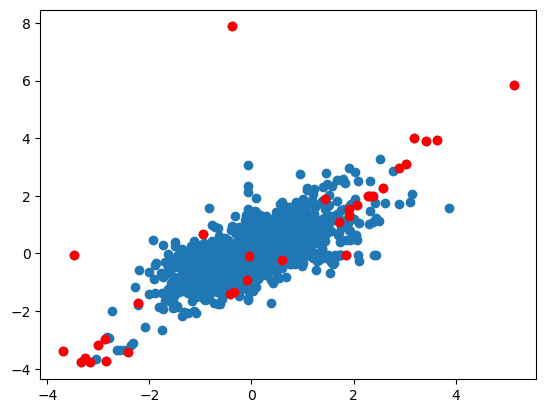

(33, 160) (1212, 160)
(1179, 160) (1179, 1)


In [ ]:
## Outlier detection with multivariate technique: gaussian mixture model
elenv = LocalOutlierFactor(n_neighbors=55)

pred = elenv.fit_predict(X_train_new)
anom_index=where(pred==-1)
values_anom = X_train_new[anom_index]

plt.scatter(X_train_new[:,0], X_train_new[:,1])
plt.scatter(values_anom[:,0],values_anom[:,1], color='r')
plt.show()
print(values_anom.shape,X_train_new.shape)
X_train_less_outliers = np.delete(X_train_new,anom_index, axis=0)
Y_train_less_outliers = np.delete(y_train.values,anom_index, axis=0)
print(X_train_less_outliers.shape,Y_train_less_outliers.shape)

In [ ]:
r1 = GradientBoostingRegressor(random_state=0)
r2 = SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=100, epsilon=0.1, shrinking=True, cache_size=2000, verbose=False, max_iter=-1)
r3 = RandomForestRegressor(max_depth=20, random_state=0)
r4 = ExtraTreesRegressor()
regr = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3), ('abr', r4)], weights=[2,3,1,1],n_jobs=None)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)


/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:600: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
model = SVR(kernel='rbf', gamma=0.01, tol=0.001, C=100, epsilon=0.1, shrinking=True, cache_size=2000, verbose=False, max_iter=-1)
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)

/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_pred.shape

(776,)

In [ ]:
pd.DataFrame({'id': [float(i) for i in range(y_pred.size)], 'y': y_pred}).to_csv('Prediction.csv')